# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with interactions and polynomial features 
- Use AIC and BIC to select the best value for the regularization parameter 


## Let's get started!

Import all the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import scale
from sklearn.preprocessing import PolynomialFeatures

Load the data.

In [2]:
df = pd.read_csv("ames.csv")

In [9]:
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

In [10]:
df

,LotArea,OverallQual,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,Fireplaces,SalePrice
0,8450,7,5,856,856,854,1710,8,548,0,208500
1,9600,6,8,1262,1262,0,1262,6,460,1,181500
2,11250,7,5,920,920,866,1786,6,608,1,223500
3,9550,7,5,756,961,756,1717,7,642,1,140000
4,14260,8,5,1145,1145,1053,2198,9,836,1,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,953,953,694,1647,7,460,1,175000
1456,13175,6,6,1542,2073,0,2073,7,500,2,210000
1457,9042,7,9,1152,1188,1152,2340,9,252,2,266500
1458,9717,5,6,1078,1078,0,1078,5,240,0,142125


## Look at a baseline housing data model

Above, we imported the Ames housing data and grabbed a subset of the data to use in this analysis.

Next steps:

- Split the data into target (`y`) and predictors (`X`) -- ensure these both are DataFrames 
- Scale all the predictors using `scale`. Convert these scaled features into a DataFrame 
- Build at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation (set `random_state` to 1) and use the $R^2$ score to evaluate the model 

In [30]:
# Your code here
X = df.iloc[:,:-1]
y = df[['SalePrice']]

X_scaled = pd.DataFrame(scale(X), columns=X.columns)

linreg = LinearRegression()

crossval = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(linreg, X_scaled, y, scoring='r2', cv=crossval)

baseline = np.mean(scores)
baseline

0.7524751004088885

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold cross-validation and store the $R^2$ to compare it with the baseline model.

Print the 7 most important interactions.

In [40]:
# Your code here
combos = list(combinations(X.columns, 2))

pos_interact = []

X1 = X_scaled.copy()

for c in combos:
    X1['interaction'] = X1[c[0]] * X1[c[1]]
    score = np.mean(cross_val_score(linreg, X1, y, scoring='r2', cv=crossval))
    if score > baseline:
        pos_interact.append([c[0],c[1],round(score,4)])

c_scores = pd.DataFrame(pos_interact, columns=['c1','c2','score'])
top_7 = c_scores.sort_values(by='score', ascending=False).head(7)
display(top_7)

,c1,c2,score
1,OverallQual,TotRmsAbvGrd,0.7697
2,OverallQual,GarageArea,0.7637
0,OverallQual,2ndFlrSF,0.7578
7,2ndFlrSF,TotRmsAbvGrd,0.7561
6,2ndFlrSF,GrLivArea,0.7560
3,OverallQual,Fireplaces,0.7542
4,OverallCond,TotalBsmtSF,0.7541


Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2", where var1 and var2 are the two variables in the interaction.

In [73]:
# Your code here
df_inter = X_scaled.copy()

for i, row in top_7.iterrows():
    df_inter[str(row['c1'] + '_' + row['c2'])] = df_inter[row['c1']]*df_inter[row['c2']]

## Include polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('OverallQual', 2, 0.781)` 

In [74]:
# Your code here
polys = []
for col in X.columns:
    for degree in [2,3,4]:
        this_df = X_scaled.copy()
        
        poly = PolynomialFeatures(degree, include_bias=False)
        X_poly = pd.DataFrame(poly.fit_transform(X[[col]]))
        
        new_X = pd.concat([X_poly, this_df.drop(col,axis=1)],axis=1)
        
        score = np.mean(cross_val_score(linreg, new_X, y, scoring='r2', cv=crossval))
        
        if score > baseline: polys.append([col, degree, round(score, 4)])
poly_data = pd.DataFrame(polys, columns=['feature', 'degree', 'score'])
poly_data = poly_data.sort_values(by='score', ascending=False)

For each variable, print out the maximum $R^2$ possible when including Polynomials.

In [75]:
# Your code here
pos_vars = poly_data.feature.unique()
for col in pos_vars:
    high = poly_data[poly_data.feature == col].score.max()
    deg = int(poly_data[poly_data.score == high].degree)
    print(col, '\t', deg, '\t', high)

GrLivArea 	 4 	 0.8069
OverallQual 	 2 	 0.7806
2ndFlrSF 	 3 	 0.7753
GarageArea 	 4 	 0.7673
OverallCond 	 4 	 0.7526
TotRmsAbvGrd 	 3 	 0.7525


Which two variables seem to benefit most from adding polynomial terms?

Add Polynomials for the two features that seem to benefit the most, as in have the best $R^2$ compared to the baseline model. For each of the two features, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [76]:
# Your code here
bests = [['GrLivArea', 4], ['OverallQual', 2]]

for best in bests:
    poly = PolynomialFeatures(best[1], include_bias=False)
    X_poly = poly.fit_transform(X[[best[0]]])
    colnames = [best[0]+'_'+str(i) for i in list(range(1,best[1]+1))]
    df_inter = pd.concat([df_inter.drop(best[0],axis=1), pd.DataFrame(X_poly, columns=colnames)], axis=1)

Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [77]:
# Your code here
df_inter

,LotArea,OverallCond,TotalBsmtSF,1stFlrSF,2ndFlrSF,TotRmsAbvGrd,GarageArea,Fireplaces,OverallQual_TotRmsAbvGrd,OverallQual_GarageArea,...,2ndFlrSF_TotRmsAbvGrd,2ndFlrSF_GrLivArea,OverallQual_Fireplaces,OverallCond_TotalBsmtSF,GrLivArea_1,GrLivArea_2,GrLivArea_3,GrLivArea_4,OverallQual_1,OverallQual_2
0,-0.207142,-0.517200,-0.459303,-0.793434,1.161852,0.912210,0.351000,-0.951226,0.594286,0.228669,...,1.059852,0.430272,-0.619704,0.237551,1710.0,2924100.0,5.000211e+09,8.550361e+12,7.0,49.0
1,-0.091886,2.179628,0.466465,0.257140,-0.795163,-0.318683,-0.060731,0.600495,0.022893,0.004363,...,0.253405,0.383676,-0.043137,1.016720,1262.0,1592644.0,2.009917e+09,2.536515e+12,6.0,36.0
2,0.073480,-0.517200,-0.313369,-0.627826,1.189351,-0.318683,0.631726,0.600495,-0.207616,0.411557,...,-0.379026,0.612531,0.391210,0.162074,1786.0,3189796.0,5.696976e+09,1.017480e+13,7.0,49.0
3,-0.096897,-0.517200,-0.687324,-0.521734,0.937276,0.296763,0.790804,0.600495,0.193335,0.515193,...,0.278149,0.359595,0.391210,0.355484,1717.0,2948089.0,5.061869e+09,8.691229e+12,7.0,49.0
4,0.375148,-0.517200,0.199680,-0.045611,1.617877,1.527656,1.698485,0.600495,2.100214,2.335068,...,2.471560,2.102150,0.825557,-0.103274,2198.0,4831204.0,1.061899e+10,2.334053e+13,8.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,-0.260560,-0.517200,-0.238122,-0.542435,0.795198,0.296763,-0.060731,0.600495,-0.021318,0.004363,...,0.235985,0.199119,-0.043137,0.123156,1647.0,2712609.0,4.467667e+09,7.358248e+12,6.0,36.0
1456,0.266407,0.381743,1.104925,2.355701,-0.795163,0.296763,0.126420,2.152216,-0.021318,-0.009081,...,-0.235975,-0.843960,-0.154607,0.421797,2073.0,4297329.0,8.908363e+09,1.846704e+13,6.0,36.0
1457,-0.147810,3.078570,0.215641,0.065656,1.844744,1.527656,-1.033914,2.152216,0.995236,-0.673574,...,2.818135,2.895598,1.402124,0.663867,2340.0,5475600.0,1.281290e+10,2.998220e+13,7.0,49.0
1458,-0.080160,0.381743,0.046905,-0.218982,-0.795163,-0.934130,-1.090059,-0.951226,0.742775,0.866762,...,0.742786,0.662202,0.756369,0.017906,1078.0,1162084.0,1.252727e+09,1.350439e+12,5.0,25.0


## Full model R-squared

Check out the $R^2$ of the full model.

In [78]:
# Your code here
full_model_r2 = np.mean(cross_val_score(linreg, df_inter, y, scoring='r2', cv=crossval))
full_model_r2

0.8226891988961489

## Find the best Lasso regularization parameter

You learned that when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter $alpha$ of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [85]:
from sklearn.linear_model import Lasso, LassoCV, LassoLarsCV, LassoLarsIC

Text(0.5, 1.0, 'AIC/BIC Model Selection - Best Alphas')

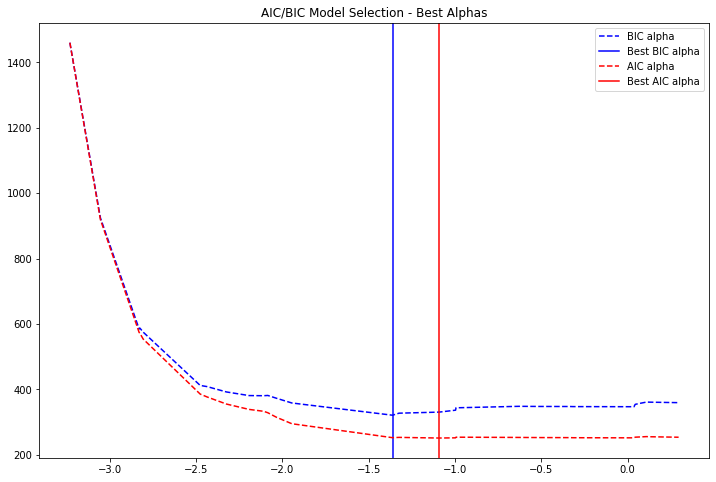

In [180]:
# Your code here 

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(df_inter, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(df_inter, y)
alpha_aic_ = model_aic.alpha_

def plot_ic_criteria(model, name, color):
    plt.plot(-np.log10(model.alphas_), model.criterion_,
             '--', color=color, label=f'{name} alpha')
    plt.axvline(-np.log10(model.alpha_), color=color, label=f'Best {name} alpha')

plt.figure(figsize=(12,8))
plot_ic_criteria(model_bic, 'BIC', 'b')
plot_ic_criteria(model_aic, 'AIC', 'r')
plt.legend()
plt.title("AIC/BIC Model Selection - Best Alphas")

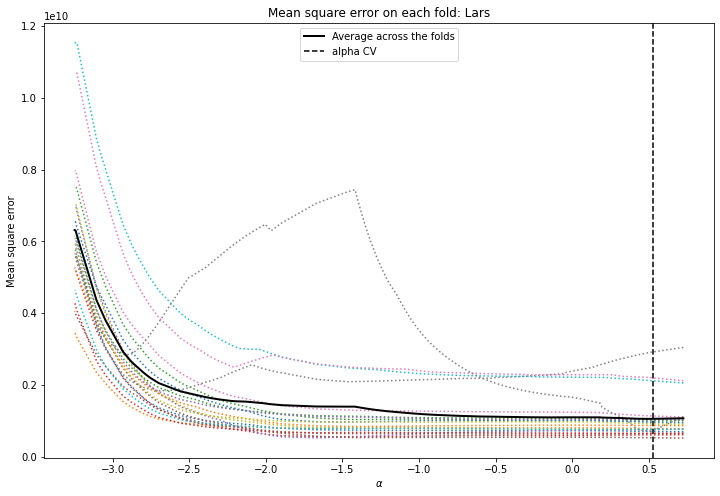

0.296579828103836 22.994367403401604 12.339362453766006


In [183]:
model_lcv = LassoLarsCV(cv=20).fit(df_inter, y)

EPSILON = 1e-4

plt.figure(figsize=(12,8))
plt.plot(-np.log10(model_lcv.cv_alphas_), model_lcv.mse_path_, ':')
plt.plot(-np.log10(model_lcv.cv_alphas_), model_lcv.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model_lcv.alpha_), linestyle='--', color='k',
            label='alpha CV')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars')
plt.show();
print(model_lcv.alpha_, alpha_bic_, alpha_aic_)

## Analyze the final result

Finally, use the best value for the regularization parameter according to AIC and BIC, and compare $R^2$ and RMSE using train-test split. Compare with the baseline model.

Remember, you can find the Root Mean Squared Error (RMSE) by setting `squared=False` inside the function (see [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)), and the RMSE returns values that are in the same units as our target - so we can see how far off our predicted sale prices are in dollars.

In [184]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

In [192]:
def print_scores(model, X_train, X_test, y_train, y_test):
    print(model)
    print(f"Training R^2: {model.score(X_train, y_train)}")
    print(f"Test R^2: {model.score(X_test, y_test)}")
    print(f"Training RMSE: {mean_squared_error(y_train, model.predict(X_train), squared=False)}")
    print(f"Test RMSE: {mean_squared_error(y_test, model.predict(X_test), squared=False)}")

In [193]:
# Split X_scaled and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)

# Code for baseline model
linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)

# Print R-Squared and RMSE
print_scores(linreg_all, X_train, X_test, y_train, y_test)

LinearRegression()
Training R^2: 0.7478270652928448
Test R^2: 0.8120708166668684
Training RMSE: 39424.15590381302
Test RMSE: 35519.17035590487


In [194]:
# Split df_inter and y into training and test sets
# Set random_state to 1
X_train, X_test, y_train, y_test = train_test_split(df_inter, y, random_state=1)

# Code for lasso with alpha from AIC
lasso = Lasso(alpha=alpha_aic_)
lasso.fit(X_train, y_train)

# Print R-Squared and RMSE
print_scores(lasso, X_train, X_test, y_train, y_test)

Lasso(alpha=12.339362453766006)
Training R^2: 0.8440239169763867
Test R^2: 0.8620953869020058
Training RMSE: 31005.745087634714
Test RMSE: 30426.717129260436


In [195]:
# Code for lasso with alpha from AIC
lasso2 = Lasso(alpha=alpha_bic_)
lasso2.fit(X_train, y_train)

# Print R-Squared and RMSE
print_scores(lasso2, X_train, X_test, y_train, y_test)

Lasso(alpha=22.994367403401604)
Training R^2: 0.8440003049204267
Test R^2: 0.8621697330903436
Training RMSE: 31008.091863078906
Test RMSE: 30418.51430211441


In [231]:
# Code for lasso with alpha from LassoCV
lasso3 = Lasso(alpha=model_lcv.alpha_)
lasso3.fit(X_train, y_train)

# Print R-Squared and RMSE
print_scores(lasso3, X_train, X_test, y_train, y_test)

Lasso(alpha=0.296579828103836)
Training R^2: 0.8440321066603119
Test R^2: 0.8619869837261288
Training RMSE: 31004.931082754996
Test RMSE: 30438.673599612914


## Level up (Optional)

### Create a Lasso path

From this section, you know that when using Lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Ames housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 